# Configure font

In [1]:
# Configure Arial as the default font in all figures

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


#arial_font_path = '/PATH/TO/ARIAL/FONT/arial.ttf'
font_dir = '/users/project/prj004631/aescobedo/miniconda3/envs/BIO/fonts/'

# Paths to both font files
arial_font_path = font_dir + 'arial.ttf'
arial_rounded_font_path = font_dir + 'arialroundedmtbold.ttf'

# Register both
fm.fontManager.addfont(arial_font_path)
fm.fontManager.addfont(arial_rounded_font_path)

# Get font properties
arial_font = fm.FontProperties(fname=arial_font_path)
arial_rounded_font = fm.FontProperties(fname=arial_rounded_font_path)

plt.rcParams["font.family"] = "Arial"

# Path to Zenodo files folder

In [1]:
path = 'PATH/TO/ZENODO/FILES/FOLDER'

In [2]:
path = '~/analyses/Cores/final_submission/zenodo/'

# Figure 6

## Panel B

In [3]:
# Correct indels in suppressor sequences

import ast
import pandas as pd

all_permissivity_seqs=pd.read_csv(path+'Fig6/Suppressor_library_allseqs.txt', sep='\t')
permi_variants = pd.read_csv(path+'Fig6/FYN_suppressor_fitness_replicates.txt', sep='\t')

all_permissivity_seqs["deletions"] = pd.Series(dtype="object") 
all_permissivity_seqs["full_variant"] = pd.Series(dtype="object") 
all_permissivity_seqs["full_variant_len"] = pd.Series(dtype="object") 
for index, row in all_permissivity_seqs.iterrows():
    if row.mutations.startswith('[')==True:
        mutations = ast.literal_eval(row.mutations)
        deletions=[]
        for mutation in mutations:
            if mutation[-1]=='-':
                deletions.append(mutation[1:-1])
        if len(deletions)>0:
            all_permissivity_seqs.at[index,'deletions']=','.join(deletions)
        full_variant=row.variant
        for deletion in deletions:
            full_variant = full_variant[:int(deletion)-1]+'-'+full_variant[int(deletion)-1:]
        all_permissivity_seqs.at[index,'full_variant']=full_variant
        all_permissivity_seqs.at[index,'full_variant_len']=len(full_variant)

In [4]:
from seaborn import kdeplot
import numpy as np
import matplotlib.pyplot as plt

def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

permi_variants_scaled = permi_variants.copy()

arbitraryWT='FLFFVIV'

fig, ax = plt.subplots()

my_kde = kdeplot(data=permi_variants.loc[permi_variants['fitness']<-0.5], x='fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])
    ax.axvline(x[np.argmax(y)], ls='--')

permi_variants_scaled['fitness']=normalize(list(permi_variants_scaled['fitness']),{'actual': {'lower': mode, 'upper': permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
permi_variants_scaled['fitness1_uncorr']=normalize(list(permi_variants_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0]['fitness1_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
permi_variants_scaled['fitness2_uncorr']=normalize(list(permi_variants_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0]['fitness2_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
permi_variants_scaled['fitness3_uncorr']=normalize(list(permi_variants_scaled['fitness3_uncorr']),{'actual': {'lower': mode, 'upper': permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0]['fitness3_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})


fig, ax = plt.subplots()

my_kde = kdeplot(data=permi_variants_scaled, x='fitness', ax=ax)

lines = my_kde.get_lines()

for line in lines:
    x, y = line.get_data()

plt.close()

In [5]:
WTs_bearing_natural_DTS_core_queries=pd.read_csv(path+'Fig6/Structural_homologs_carrying_detrimental_cores_in_FYN.txt',sep='\t')

permi_variants_scaled["other_natural_SH3s"] = pd.Series(dtype="object") 
permi_variants_scaled["Pro_mutant"] = pd.Series(dtype="object") 
for index, row in permi_variants_scaled.iterrows():
    if row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['DSSP_boundaries']) or row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['Pro_mutant_1']) or row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['Pro_mutant_2']) or row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['Pro_mutant_3']):
        permi_variants_scaled.at[index,'other_natural_SH3s']=True
        if row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['DSSP_boundaries']):
            permi_variants_scaled.at[index,'Pro_mutant']=False
        else:
            permi_variants_scaled.at[index,'Pro_mutant']=True

other_natural_SH3s = permi_variants_scaled.loc[permi_variants_scaled['other_natural_SH3s']==True].copy()

In [6]:
# Find core and hamming distances

fyn_core_pos = [2,16,18,24,26,48,53]
fyn_wt_core = 'FLFFIIV'
fyn_permi_variants = permi_variants_scaled.loc[permi_variants_scaled['other_natural_SH3s']!=True].copy()
fyn_wt_seq = permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0].iloc[0]['aa_seq']
fyn_permi_variants["full_variant"] = pd.Series(dtype="object") 
fyn_permi_variants["core"] = pd.Series(dtype="object") 
fyn_permi_variants["all_mutations"] = pd.Series(dtype="object") 
for index, row in fyn_permi_variants.iterrows():
    fyn_permi_variants.at[index,'full_variant']=all_permissivity_seqs.loc[all_permissivity_seqs['variant']==row.aa_seq].iloc[0]['full_variant']
    core=[]
    for i in fyn_core_pos:
        core.append(all_permissivity_seqs.loc[all_permissivity_seqs['variant']==row.aa_seq].iloc[0]['full_variant'][i])
    fyn_permi_variants.at[index,'core'] = ''.join(core)
    fyn_permi_variants.at[index, 'Nham_core'] = sum(1 for a,b in zip(core, fyn_wt_core) if a!=b)
    fyn_permi_variants.at[index, 'Nham_aa'] = sum(1 for a,b in zip(all_permissivity_seqs.loc[all_permissivity_seqs['variant']==row.aa_seq].iloc[0]['full_variant'], fyn_wt_seq) if a!=b)
    if len(row.aa_seq) != len(permi_variants.loc[permi_variants['Nham_aa']==0].iloc[0]['aa_seq']):
        fyn_permi_variants.at[index,'indel']=True
    fyn_permi_variants.at[index,'len']=len(row.aa_seq)

for index, row in fyn_permi_variants.iterrows():
    mutations=[]
    iterator=1
    for wt, mut in zip(fyn_wt_seq, row.full_variant):
        if wt != mut:
            mutations.append(wt+str(iterator)+mut)
        iterator+=1
    fyn_permi_variants.at[index,'all_mutations']=','.join(mutations)

In [7]:
# Discern query types

detrimental_singles_FYN = pd.read_csv(path+'Fig6/Suppressor_lib_singles_queries.txt', sep='\t', index_col=0)
query_natural_DTS_cores = pd.read_csv(path+'Fig6/Suppressor_lib_transplant_queries.txt', sep='\t', index_col=0)

fyn_permi_variants["query_type"] = pd.Series(dtype="object") 
for index, row in fyn_permi_variants.iterrows():
    if row.core in list(query_natural_DTS_cores.index):
        fyn_permi_variants.at[index,'query_type'] = 'Natural Core'
    else:
        fyn_permi_variants.at[index,'query_type'] = 'Single mutant'

In [8]:
# Find mutations and hamming distance to each core transplant query

natural_core_queries = fyn_permi_variants.loc[fyn_permi_variants['query_type']=='Natural Core'].copy()
fyn_wt_seq = fyn_permi_variants.loc[fyn_permi_variants['Nham_aa']==0].iloc[0]['aa_seq']
fyn_core_pos = [2,16,18,24,26,48,53]

for natural_query in list(query_natural_DTS_cores.index):
    natural_core_queries[natural_query+'_mutations'] = pd.Series(dtype="object") 
    
for natural_query in list(query_natural_DTS_cores.index):
    query_seq=fyn_wt_seq
    for mut_res, pos in zip(natural_query,fyn_core_pos):
        query_seq = query_seq[:pos]+mut_res+query_seq[pos+1:]
    for index, row in natural_core_queries.iterrows():
        if row.core == natural_query:
            natural_core_queries.at[index,natural_query+'_total_Nham'] = sum(1 for a,b in zip(row.full_variant, query_seq) if a!=b)
            mutations=[]
            iterator=1
            for wt, mut in zip(query_seq, row.full_variant):
                if wt != mut:
                    mutations.append(wt+str(iterator)+mut)
                iterator+=1
            natural_core_queries.at[index,natural_query+'_mutations']=','.join(mutations)

In [9]:
for group in natural_core_queries.groupby('core'):
    query_natural_DTS_cores.at[group[1].iloc[0]['core'],'suppressor_attempts']=len(group[1])

In [10]:
natural_core_queries

,nt_seq,aa_seq,Nham_nt,Nham_aa,Nmut_codons,WT,indel,STOP,STOP_readthrough,count_e1_s0,...,VLIIVFV_mutations,FLLVVFV_mutations,VLFIVFV_total_Nham,VLFIIFV_total_Nham,VLLIVFV_total_Nham,VLFILFV_total_Nham,VLLVVFV_total_Nham,VLFLVFV_total_Nham,VLIIVFV_total_Nham,FLLVVFV_total_Nham
12,NaN,TKVTALYDYEARTEDDLSFHKGEKIQILNSSEGDWWEARSLTTGET...,NaN,5.0,NaN,NaN,False,False,False,359,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,TKVTALYDYEARTEDDLSFHKGEKIQILNSSEGDWWEGRSLTTGET...,NaN,7.0,NaN,NaN,False,False,False,14,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,TKVTALYDYEARTEDDLSFHKGEKIQVLNSSEGDWWEARSLTTGET...,NaN,6.0,NaN,NaN,False,False,False,337,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,TKVQALYDYEATEESDLSFHKGEKIQVLNSSEGDWWEASLTTGETG...,NaN,11.0,NaN,NaN,True,False,False,1667,...,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,TKVQALYDYEARTEDDLSFHKGEKIQVLNSSEGDWWEARSLTTGET...,NaN,6.0,NaN,NaN,False,False,False,464,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10400,NaN,TLFVALYSYEARTEDDLSLHKGEKVQVLNSSDGDWWEARSLTTGET...,NaN,6.0,NaN,NaN,False,False,False,765,...,NaN,"D8S,E32D",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
10450,NaN,TLFVALYSYEARGEDDLSLHKGEKVQVLNSSEGDWWEARSLTTGET...,NaN,6.0,NaN,NaN,False,False,False,846,...,NaN,"D8S,T13G",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
10455,NaN,TLFVALYSYVARTEDDLSLQKGEKVQVLNSSDGDWWEGRSLTTGET...,NaN,9.0,NaN,NaN,False,False,False,1488,...,NaN,"D8S,E10V,H20Q,E32D,A38G",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
10456,NaN,TLFVALYSYVARTEDDLSLHKGEKVQVLNSSEGDWWEARSLTTGET...,NaN,6.0,NaN,NaN,False,False,False,1072,...,NaN,"D8S,E10V",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [11]:
coefs_2ndorder = pd.read_csv(path+'FigS5/FYN_ddGs_scaled_from_additivetrait_order2.txt',
                       sep='\t', index_col=0)
secondorderterms_2ndorder = pd.read_csv(path+'FigS5/FYN_mochiorder2_secondorderterms_scaled_w_iv_values.txt',
                       sep='\t', index_col=0)

folding_ddGs = coefs_2ndorder[['actual_ddGs','scaled_std']].copy().rename(columns={'actual_ddGs':'ddG'})
folding_dddGs = secondorderterms_2ndorder[['id','scaled_ddGs','scaled_ddG_std']].copy().set_index('id',drop=True).rename(columns={'scaled_ddGs':'dddG','scaled_ddG_std':'scaled_std'})


In [12]:
# Definitions

P06241 = 'ACGCTTTTCGTTGCATTGTATGATTATGAAGCAAGAACTGAAGATGATTTGTCTTTCCATAAAGGTGAAAAATTCCAAATCTTGAATTCTTCTGAAGGTGATTGGTGGGAAGCAAGATCTTTGACTACTGGTGAAACTGGTTATATCCCATCTAACTATGTCGCGCCTGTG'

cores = {'P06241' : [2,16,18,24,26,48,53]}

In [13]:
predicted_phenotypes = pd.read_csv(path+'Fig3/FYN-SH3/FYN_mochi_order2/task_1/predictions/predicted_phenotypes_supp.txt',
                                  sep='\t', lineterminator='\n', low_memory=False, index_col=0)

predicted_phenotypes["core"] = pd.Series(dtype="object") 
for index, row in predicted_phenotypes.iterrows():
    core=[]
    for i in cores['P06241']:
        core.append(row.aa_seq[i])
    predicted_phenotypes.at[index,'core'] = ''.join(core)

RT=303*0.001987
predicted_phenotypes['mean_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].mean(axis=1)
predicted_phenotypes['std_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].std(axis=1)

predicted_phenotypes['mean_dG']= predicted_phenotypes['mean_additive_trait']*RT - predicted_phenotypes.loc[predicted_phenotypes['WT']==True].iloc[0]['mean_additive_trait']*RT
predicted_phenotypes['std_dG']= predicted_phenotypes['std_additive_trait']*RT

In [14]:
import pandas as pd
from itertools import combinations

fyn_wt = 'TLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPV'

mut_pos_name = [2,16,18,24,26,48,53]

def find_mutations(wt, variant, positions):
    mutations = []
    for pos in positions:
        if wt[pos] != variant[pos]:
            mutations.append(f"{wt[pos]}{pos + 1}{variant[pos]}")
    return mutations

predicted_phenotypes['mutations'] = predicted_phenotypes['aa_seq'].apply(lambda x: ','.join(find_mutations(fyn_wt, x, mut_pos_name)))

def find_mutation_pairs(mutations):
    mutation_list = mutations.split(',')
    pairs = [f"{a}_{b}" for a, b in combinations(mutation_list, 2)]
    return ','.join(pairs)

predicted_phenotypes['mutation_pairs'] = predicted_phenotypes['mutations'].apply(lambda x: find_mutation_pairs(x) if x else '')


In [15]:
def compute_iv_scaled_dddG(row, folding_ddGs, folding_dddGs):
    single_mutations = row['mutations'].split(',') if row['mutations'] else []
    mutation_pairs = row['mutation_pairs'].split(',') if row['mutation_pairs'] else []

    ddG_sum = sum(folding_ddGs.loc[mut, 'ddG'] for mut in single_mutations if mut in folding_ddGs.index)

    dddG_sum = sum(folding_dddGs.loc[pair, 'dddG'] for pair in mutation_pairs if pair in folding_dddGs.index)

    return ddG_sum + dddG_sum

predicted_phenotypes['iv_scaled_folding_ddG'] = predicted_phenotypes.apply(compute_iv_scaled_dddG, axis=1, folding_ddGs=folding_ddGs, folding_dddGs=folding_dddGs)

In [16]:
import numpy as np


def compute_iv_scaled_dddG_and_error(row, folding_ddGs, folding_dddGs):
    single_mutations = row['mutations'].split(',') if row['mutations'] else []
    mutation_pairs = row['mutation_pairs'].split(',') if row['mutation_pairs'] else []

    ddG_sum = 0.0
    dddG_sum = 0.0
    ddG_error_squared = 0.0
    dddG_error_squared = 0.0

    for mut in single_mutations:
        if mut in folding_ddGs.index:
            ddG_sum += folding_ddGs.loc[mut, 'ddG']
            ddG_error_squared += folding_ddGs.loc[mut, 'scaled_std'] ** 2
    for pair in mutation_pairs:
        if pair in folding_dddGs.index:
            dddG_sum += folding_dddGs.loc[pair, 'dddG']
            dddG_error_squared += folding_dddGs.loc[pair, 'scaled_std'] ** 2

    total_ddG = ddG_sum + dddG_sum

    total_error = np.sqrt(ddG_error_squared + dddG_error_squared)

    return pd.Series([total_ddG, total_error])

predicted_phenotypes[['iv_scaled_folding_ddG', 'iv_scaled_folding_ddG_std']] = \
    predicted_phenotypes.apply(
        compute_iv_scaled_dddG_and_error, 
        axis=1, 
        folding_ddGs=folding_ddGs, 
        folding_dddGs=folding_dddGs
    )

In [17]:
iv_scaled_query_natural_DTS_cores = predicted_phenotypes.loc[predicted_phenotypes['core'].isin(list(query_natural_DTS_cores.index))][['core','mean_dG','iv_scaled_folding_ddG','iv_scaled_folding_ddG_std']].copy()
iv_scaled_query_natural_DTS_cores = iv_scaled_query_natural_DTS_cores.set_index('core',drop=True).reindex(list(query_natural_DTS_cores.index))
query_natural_DTS_cores.merge(iv_scaled_query_natural_DTS_cores,left_index=True,right_index=True)[['Instances','iv_scaled_folding_ddG','iv_scaled_folding_ddG_std','suppressor_attempts']]

,Instances,iv_scaled_folding_ddG,iv_scaled_folding_ddG_std,suppressor_attempts
VLFIVFV,3512,6.174721,0.824688,363.0
VLFIIFV,607,5.846500,0.740975,261.0
VLLIVFV,335,6.967718,0.930117,255.0
VLFILFV,243,6.537155,0.810680,241.0
VLLVVFV,226,7.154358,0.946111,234.0
VLFLVFV,184,4.386921,0.814176,247.0
VLIIVFV,182,7.625454,1.048469,251.0
FLLVVFV,140,4.074975,0.887344,257.0


In [18]:
detrimental_singles_FYN = pd.read_csv(path+'Fig6/Suppressor_lib_singles_queries.txt', sep='\t', index_col=0)
detrimental_singles_FYN = detrimental_singles_FYN.set_index('variant',drop=True)

single_mutant_queries = fyn_permi_variants.loc[fyn_permi_variants['query_type']=='Single mutant'].copy()

detrimental_singles_FYN["suppressor_attempts"] = pd.Series(dtype="object") 
for single_mut in list(detrimental_singles_FYN.index):
    counter=0
    for index, row in single_mutant_queries.iterrows():
        if single_mut in row.all_mutations.split(','):
            counter+=1
    detrimental_singles_FYN.at[single_mut,'suppressor_attempts']=counter
    
scaled_ddGs_detrimental_singles_FYN = predicted_phenotypes.loc[predicted_phenotypes['mutations'].isin(list(detrimental_singles_FYN.index))].copy()
scaled_ddGs_detrimental_singles_FYN = scaled_ddGs_detrimental_singles_FYN.set_index('mutations',drop=True).reindex(list(detrimental_singles_FYN.index))
detrimental_singles_FYN.merge(scaled_ddGs_detrimental_singles_FYN[['iv_scaled_folding_ddG','iv_scaled_folding_ddG_std']],left_index=True,right_index=True)[['Positional_mut_count','iv_scaled_folding_ddG','iv_scaled_folding_ddG_std','suppressor_attempts']]

,Positional_mut_count,iv_scaled_folding_ddG,iv_scaled_folding_ddG_std,suppressor_attempts
F3L,1850.0,1.089101,0.085766,164
F3I,756.0,1.548978,0.160746,185
L17V,2104.0,1.952142,0.188572,489
F19L,14045.0,1.080157,0.175833,845
F19I,3791.0,0.777137,0.261384,182
F19V,5337.0,1.952572,0.201350,912
F25M,1184.0,1.370938,0.160575,211
F25V,11692.0,1.868039,0.137380,1244
I27F,181.0,2.317115,0.242725,174
I27L,7674.0,0.656825,0.185641,324


## Panel C

In [19]:
import math

for index, row in WTs_bearing_natural_DTS_core_queries.iterrows():
    try:
        WTs_bearing_natural_DTS_core_queries.at[index,'query_seq_fitness']=other_natural_SH3s.loc[other_natural_SH3s['aa_seq']==row.DSSP_boundaries].iloc[0]['fitness']
        WTs_bearing_natural_DTS_core_queries.at[index,'query_seq_gr']=other_natural_SH3s.loc[other_natural_SH3s['aa_seq']==row.DSSP_boundaries].iloc[0]['growthrate']
    except IndexError:
        continue
    try:
        WTs_bearing_natural_DTS_core_queries.at[index,'Pro_mutant_1_fitness']=other_natural_SH3s.loc[other_natural_SH3s['aa_seq']==row.Pro_mutant_1].iloc[0]['fitness']
        WTs_bearing_natural_DTS_core_queries.at[index,'Pro_mutant_1_gr']=other_natural_SH3s.loc[other_natural_SH3s['aa_seq']==row.Pro_mutant_1].iloc[0]['growthrate']
    except IndexError:
        continue
    try:
        WTs_bearing_natural_DTS_core_queries.at[index,'Pro_mutant_2_fitness']=other_natural_SH3s.loc[other_natural_SH3s['aa_seq']==row.Pro_mutant_2].iloc[0]['fitness']
        WTs_bearing_natural_DTS_core_queries.at[index,'Pro_mutant_2_gr']=other_natural_SH3s.loc[other_natural_SH3s['aa_seq']==row.Pro_mutant_2].iloc[0]['growthrate']
    except IndexError:
        continue
    try:
        WTs_bearing_natural_DTS_core_queries.at[index,'Pro_mutant_3_fitness']=other_natural_SH3s.loc[other_natural_SH3s['aa_seq']==row.Pro_mutant_3].iloc[0]['fitness']
        WTs_bearing_natural_DTS_core_queries.at[index,'Pro_mutant_3_gr']=other_natural_SH3s.loc[other_natural_SH3s['aa_seq']==row.Pro_mutant_3].iloc[0]['growthrate']
    except IndexError:
        continue

for index, row in WTs_bearing_natural_DTS_core_queries.iterrows():
    grs = []
    fitnesses = []
    for i in range(1,4,1):
        if math.isnan(row['Pro_mutant_'+str(i)+'_gr']) == False:
            grs.append(row['Pro_mutant_'+str(i)+'_gr'])
            fitnesses.append(row['Pro_mutant_'+str(i)+'_fitness'])
    if len(grs) > 0:
        WTs_bearing_natural_DTS_core_queries.at[index,'mean_Pro_mutant_gr']=sum(grs)/len(grs)
        WTs_bearing_natural_DTS_core_queries.at[index,'mean_Pro_mutant_fitness']=sum(fitnesses)/len(fitnesses)

In [20]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)

    return newcmap

iterator_cmap = 0

In [21]:
WTs_bearing_natural_DTS_core_queries = WTs_bearing_natural_DTS_core_queries.sort_values('query_seq_fitness', ascending=False)

top_WTs_bearing_natural_DTS_core_queries=pd.DataFrame()
for group in WTs_bearing_natural_DTS_core_queries.groupby('MutCore'):
    top_WTs_bearing_natural_DTS_core_queries= pd.concat([top_WTs_bearing_natural_DTS_core_queries, group[1].iloc[:3]], axis=0)

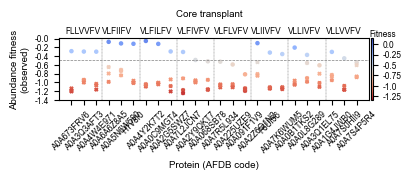

In [22]:
orig_cmap = plt.cm.coolwarm_r
norm = plt.Normalize(vmin=np.min(permi_variants_scaled['fitness']), vmax=np.max(permi_variants_scaled['fitness']))
iterator_cmap+=1
midpoint=(-0.5 - np.min(permi_variants_scaled['fitness']))/ (np.max(permi_variants_scaled['fitness']) - np.min(permi_variants_scaled['fitness']))
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=midpoint, name='shifted'+str(iterator_cmap))

fig, ax = plt.subplots(figsize=(4,0.8))

len_previous=top_WTs_bearing_natural_DTS_core_queries.loc[top_WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[top_WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['MutCore'].value_counts().loc[list(top_WTs_bearing_natural_DTS_core_queries.loc[top_WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[top_WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['MutCore'].unique())[0]]
position=0
for natcore in list(top_WTs_bearing_natural_DTS_core_queries.loc[top_WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[top_WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['MutCore'].unique()):
    len_current=top_WTs_bearing_natural_DTS_core_queries.loc[top_WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[top_WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['MutCore'].value_counts().loc[natcore]
    plt.text(position-0.5+(len_current-min(top_WTs_bearing_natural_DTS_core_queries.loc[top_WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[top_WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['MutCore'].value_counts()))/2, 0.1, natcore, fontsize=6, rotation=0)
    len_previous=top_WTs_bearing_natural_DTS_core_queries.loc[top_WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[top_WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['MutCore'].value_counts().loc[natcore]
    position=len_previous+position
    if list(top_WTs_bearing_natural_DTS_core_queries.loc[top_WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[top_WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['MutCore'].unique()).index(natcore) != len(list(top_WTs_bearing_natural_DTS_core_queries.loc[top_WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[top_WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['MutCore'].unique()))-1:
        plt.axvline(position-0.5, ls='--', color='k', lw=0.2)
    
fig.text(0.5, 1.15, 'Core transplant', ha='center', fontsize=7)
    
top_WTs_bearing_natural_DTS_core_queries=top_WTs_bearing_natural_DTS_core_queries.sort_values(['MutCore','query_seq_fitness'], ascending=[True,False])
top_WTs_bearing_natural_DTS_core_queries.loc[top_WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[top_WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()].plot.scatter(x='AF_code', y='query_seq_fitness', s=5, ax=ax, c = shifted_cmap(norm(top_WTs_bearing_natural_DTS_core_queries.loc[top_WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[top_WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['query_seq_fitness'])))
for pro_mutant in range(1,4,1):
    top_WTs_bearing_natural_DTS_core_queries.loc[top_WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[top_WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()].plot.scatter(x='AF_code', y='Pro_mutant_'+str(pro_mutant)+'_fitness', s=5, marker='x', ax=ax, c = shifted_cmap(norm(top_WTs_bearing_natural_DTS_core_queries.loc[top_WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[top_WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['Pro_mutant_'+str(pro_mutant)+'_fitness'])))
plt.axhline(-0.5, color='gray', ls='--', lw=0.5)
ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(),rotation=45, fontsize=6)
ax.set_yticks(np.arange(-1.4,0.1,0.2),[str(round(i,1)) for i in np.arange(-1.4,0.1,0.2)], fontsize=6)
ax.set_xlabel('Protein (AFDB code)', fontsize=7)
ax.set_ylabel('Abundance fitness\n(observed)', fontsize=7)
plt.xlim(-1,len(top_WTs_bearing_natural_DTS_core_queries.loc[top_WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[top_WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()].index))

cax=fig.add_axes([0.905,0.11,0.005,0.77])
cb=fig.figure.colorbar(plt.cm.ScalarMappable(cmap=orig_cmap, norm=norm), cax=cax, orientation='vertical')
cax.set_yticks(np.arange(-1.25,0.25,0.25), np.arange(-1.25,0.25,0.25), fontsize=6)
cb.outline.set_visible(True)
cb.ax.set_title('Fitness', fontsize=6, pad=-1.5, x=6)

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Proteins_with_detrimental_cores_in_FYN_fitness_top3.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel D

In [23]:
import pandas as pd
from os import listdir
from os.path import isfile, join

columns = ['Query','Target','E-value','SeqId','QueryStart', 'QueryEnd','QueryLen', 'TargetStart',
          'TargetEnd','TargetLen', 'Align_len', 'Score', 'QuerySeq', 'TargetSeq', 'mismatch',
           'QueryCov','TargetCov', 'taxid','taxname','taxlineage','lddt','alntmscore','rmsd','prob']

isofolds=pd.read_csv(path+'Fig4/fyn_aln1_AFUniprot',names=columns,sep='\t')

reliable_isofolds = isofolds.loc[isofolds['alntmscore']>0.6].loc[isofolds['prob']==1].loc[isofolds['QueryStart']<3].loc[isofolds['QueryEnd']>53].loc[isofolds['rmsd']<2].drop_duplicates('TargetSeq').copy()

In [24]:
#transplantable core finding

DTS=['F','L','I','M','V']

wt=reliable_isofolds.iloc[0]['QuerySeq']
mut_pos = [2,16,18,24,26,48,53]
wtcore=''.join([reliable_isofolds.iloc[0]['QuerySeq'][i] for i in mut_pos])

aatype_pos=[]
for i in mut_pos:
    aatyperange=0
    for res in wt[:i]:
        if res == wt[i-1]:
            aatyperange+=1
    aatype_pos.append(aatyperange)
reliable_isofolds['MutPosinlib']='a'
reliable_isofolds["WTcore"] = pd.Series(dtype="object") 
reliable_isofolds["MutCore"] = pd.Series(dtype="object") 
reliable_isofolds["TransplantableAAs"] = pd.Series(dtype="object") 
reliable_isofolds["allDTS"] = pd.Series(dtype="object") 
reliable_isofolds["coreDels"] = pd.Series(dtype="object") 
reliable_isofolds["MutPosTested"] = pd.Series(dtype="object") 
totalerrors=0
for index, row in reliable_isofolds.iterrows():
    query=row.QuerySeq
    target=row.TargetSeq
    target_mut_pos=[]
    query_hyphens=[]
    iterator=0
    for i in query:
        if i=='-':
            query_hyphens.append(iterator)
        iterator+=1
    aligned_target=list(target)
    iterator=0
    for i in query_hyphens:
        del(aligned_target[i+iterator])
        iterator-=1
    aligned_target=''.join(aligned_target)
    mut_pos_test = [x+1 - row.QueryStart for x in mut_pos]
    mut_pos_test = [i - row.QueryStart +1 for i in mut_pos if i >= row.QueryStart-1 and i <= row.QueryEnd-1]
    mut=[]
    for pos in mut_pos_test:
        try:
            mut.append(aligned_target[pos])
        except IndexError:
            totalerrors+=1
    if ''.join(mut) == wtcore:
        reliable_isofolds.at[index,'WTcore']=True
        reliable_isofolds.at[index,'Nham']=0
    else:
        reliable_isofolds.at[index,'WTcore']=False
        nham=0
        for mutres, wtres in zip(mut,wtcore):
            if mutres != wtres:
                nham+=1
        reliable_isofolds.at[index,'Nham']=nham
        
    reliable_isofolds.at[index,'MutCore']=('').join(mut)
    allDTS=True
    coreDels=False
    mutations_in_lib = []
    transplantable_aas = []
    for pos, res in zip([idx for idx, pos in enumerate(mut_pos) if pos >= row.QueryStart-1 and pos <= row.QueryEnd-1], mut):
        if res not in DTS:
            allDTS=False
        else:
            mutations_in_lib.append(mut_pos[pos])
            transplantable_aas.append(res)
        if res == '-':
            coreDels=True
    reliable_isofolds.at[index,'MutPosinlib']=str(mutations_in_lib)
    reliable_isofolds.at[index,'TransplantableAAs']=''.join(transplantable_aas)
    reliable_isofolds.at[index,'allDTS']=allDTS
    reliable_isofolds.at[index,'coreDels']=coreDels 
    reliable_isofolds.at[index,'MutPosTested']=str([i for i in mut_pos if i >= row.QueryStart-1 and i <= row.QueryEnd-1])


In [25]:
all_structure_MSA = pd.read_csv(path+'Fig6/FYN_SH3_filtered_struct_homologs_MSA_noindel.txt', sep='\t',index_col=0)

/users/project/prj004631/aescobedo/miniconda3/envs/BIO/lib/python3.12/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character '-' is not in color_dict. Using black.
  warnings.warn(str(Error))


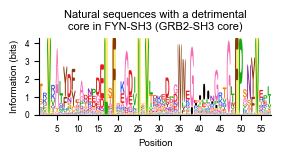

In [26]:
import logomaker as lm

plt.rcParams['font.family'] = [arial_font.get_name(), arial_rounded_font.get_name()]

aas=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y','-']

GRB2_core=query_natural_DTS_cores.sort_values('Instances',ascending=False).iloc[0].name

cores = {'P06241' : [2,16,18,24,26,48,53]}

fig, ax = plt.subplots(figsize=(3,1))

structure_MSA = all_structure_MSA.loc[list(reliable_isofolds.loc[reliable_isofolds['MutCore']==GRB2_core]['Target'])]

logo_df = pd.DataFrame(columns=aas)
    
for pos in range(1,len(structure_MSA.columns)+1,1):
    df = structure_MSA[str(pos)].value_counts().rename_axis('aa').reset_index(name='counts')
    
    for index, row2 in df.iterrows():
        logo_df.at[pos,row2.aa]=int(row2.counts)
logo_df=logo_df.fillna(0)

prob_mat = lm.transform_matrix(logo_df, from_type='counts', to_type='information')
logo=lm.Logo(prob_mat, font_name = 'Arial Rounded MT Bold', ax=ax, color_scheme='dmslogo_funcgroup')
for pos in [i+1 for i in cores['P06241']]:
    logo.highlight_position(p=pos, color='gold', alpha=.5)
ax.spines[['right','top']].set_visible(False)
ax.set_xticks(range(5,60,5),range(5,60,5), fontsize=6)
ax.set_yticks(range(0,5,1),range(0,5,1), fontsize=6)
plt.xlabel('Position', fontsize=7)
plt.ylabel('Information (bits)', fontsize=7)
plt.title('Natural sequences with a detrimental\ncore in FYN-SH3 (GRB2-SH3 core)',fontsize=8)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('GRB2-like_seqs.svg', dpi=300, transparent=True, bbox_inches='tight')

/users/project/prj004631/aescobedo/miniconda3/envs/BIO/lib/python3.12/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character '-' is not in color_dict. Using black.
  warnings.warn(str(Error))


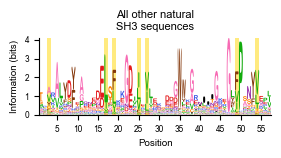

In [27]:
import logomaker as lm

aas=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y','-']

GRB2_core=query_natural_DTS_cores.sort_values('Instances',ascending=False).iloc[0].name

cores = {'P06241' : [2,16,18,24,26,48,53]}

fig, ax = plt.subplots(figsize=(3,1))

structure_MSA = all_structure_MSA.loc[list(reliable_isofolds.loc[reliable_isofolds['MutCore']!=GRB2_core]['Target'])]

logo_df = pd.DataFrame(columns=aas)
    
for pos in range(1,len(structure_MSA.columns)+1,1):
    df = structure_MSA[str(pos)].value_counts().rename_axis('aa').reset_index(name='counts')
    
    for index, row2 in df.iterrows():
        logo_df.at[pos,row2.aa]=int(row2.counts)
logo_df=logo_df.fillna(0)

prob_mat = lm.transform_matrix(logo_df, from_type='counts', to_type='information')
logo=lm.Logo(prob_mat, font_name = 'Arial Rounded MT Bold', ax=ax, color_scheme='dmslogo_funcgroup')
for pos in [i+1 for i in cores['P06241']]:
    logo.highlight_position(p=pos, color='gold', alpha=.5)
ax.spines[['right','top']].set_visible(False)
ax.set_xticks(range(5,60,5),range(5,60,5), fontsize=6)
ax.set_yticks(range(0,5,1),range(0,5,1), fontsize=6)
plt.xlabel('Position', fontsize=7)
plt.ylabel('Information (bits)', fontsize=7)
plt.title('All other natural\nSH3 sequences',fontsize=8)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('GRB2-dislike_seqsr.svg', dpi=300, transparent=True, bbox_inches='tight')

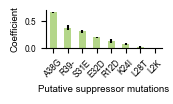

In [28]:
plt.rcParams["font.family"] = "Arial"

suppressor_mutations = pd.read_csv(path+'Fig6/Suppressor_mutation_identification_example.txt',sep='\t')

fig,ax = plt.subplots(figsize=(1.5,0.5))
suppressor_mutations.plot.bar(x='Permissivity_variant',y='Permissivity_coef',yerr='Permissivity_coef_std',ax=ax, color='#B4D689')
plt.xlabel('Putative suppressor mutations', fontsize=7)
plt.ylabel('Coefficient', fontsize=7)
plt.xticks(fontsize=6, rotation=45)
plt.yticks(fontsize=6)
ax.get_legend().remove()
ax.spines[['right','top']].set_visible(False)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('GRB2-logreg_coefs_fig.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel E

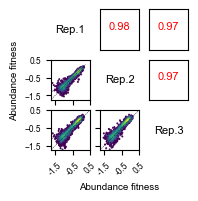

In [29]:
from scipy.stats import pearsonr
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'Arial'

warnings.filterwarnings('ignore')

def reg_coef(x,y,label=None,color=None,hue=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('{:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center', size = 8, color='red')
    ax.tick_params(right=False, top=False, left=False, bottom=False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    #ax.tick_params(axis='both', which='major', labelsize=14)
def replicate(x,**kwargs):
    ax = plt.gca()
    ax.text(.5,.5,'Rep.'+x.name[7:8],size=8,ha='center',va='center', transform=ax.transAxes)
    ax.set_axis_off()
def hexbin(x, y, color, **kwargs): #https://stackoverflow.com/questions/40495093/hexbin-plot-in-pairgrid-with-seaborn
    ax = plt.gca()
    cmap = sns.color_palette('viridis', as_cmap=True)
    ax.hexbin(x, y, bins='log',gridsize=50, cmap=cmap, extent=[min(x), max(x), min(y), max(y)], **kwargs, rasterized=True)
    lims = np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])
    plt.plot(lims, lims, '--', color='k', linewidth=0.3)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.set_ylim(-1.75,0.5)
    ax.set_xlim(-1.75,0.5)
    ax.set_xticks(np.arange(-1.5,1.5,1))
    ax.set_xticklabels(np.arange(-1.5,1.5,1), rotation=45)
    ax.set_yticks(np.arange(-1.5,1.5,1))
    ax.tick_params(axis='both', which='major', labelsize=6)

g = sns.PairGrid(permi_variants_scaled[['fitness1_uncorr', 'fitness2_uncorr', 'fitness3_uncorr']].dropna())
g.map_upper(reg_coef, hue=None)
g.map_diag(replicate)
g.map_lower(hexbin)
g.fig.set_size_inches(1.56,1.56)
#g.fig.tight_layout()

for i in range(3):
    g.axes[i, i].set_visible(False)

plt.subplots_adjust(hspace=0.25, wspace=0.25)
            
for ax in g.axes.flatten():
    if ax.get_xlabel() != '':
        if str(ax.get_xlabel().split('_')[0][-1]) == '1' or str(ax.get_xlabel().split('_')[0][-1]) == '3': 
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Abundance fitness', fontsize=7)
    if ax.get_ylabel() != '':
        if str(ax.get_ylabel().split('_')[0][-1]) == '1' or str(ax.get_ylabel().split('_')[0][-1]) == '3':
            ax.set_ylabel('')
        else:
            ax.set_ylabel('Abundance fitness', fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_permissivity_Fitness_correl.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel F

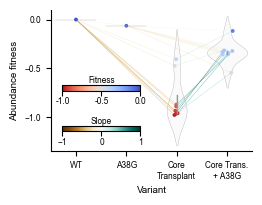

In [30]:
import random
import networkx as nx
plt.rcParams["font.family"] = "Arial"

ylim_top = 0
ylim_bottom = 0
for core_query in list(query_natural_DTS_cores.index):
    rescue_single='A38G'
    core_mutations=[]
    for wt_res, pos, mut_res in zip(fyn_wt_core, fyn_core_pos, core_query):
        if wt_res != mut_res:
            core_mutations.append(wt_res+str(pos+1)+mut_res)
    combined_mutations = sorted(core_mutations +rescue_single.split(','), key=lambda x: (int(x[1:-1]), x[-1]) )
    mutations = ['',rescue_single,','.join(core_mutations),','.join(combined_mutations)]
    for mutation in mutations:
        if fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==mutation].iloc[0]['fitness'] > ylim_top:
            ylim_top = fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==mutation].iloc[0]['fitness']
        if fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==mutation].iloc[0]['fitness'] < ylim_bottom:
            ylim_bottom = fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==mutation].iloc[0]['fitness']

orig_cmap = plt.cm.coolwarm_r
norm = plt.Normalize(vmin=round(ylim_bottom,1), vmax=round(ylim_top,1))
iterator_cmap+=1
midpoint=(-0.5 - ylim_bottom/ (ylim_top - ylim_bottom))
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=midpoint, name='shifted'+str(iterator_cmap))

rescue_single_scatter_df=pd.DataFrame()
rescue_single_scatter_df.at[0,'variant_type']='WT'
rescue_single_scatter_df.at[0,'mutation']='WT'
rescue_single_scatter_df.at[0,'fitness']=fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==''].iloc[0]['fitness']
rescue_single_scatter_df.at[0,'scatter_pos']=0
rescue_single_scatter_df.at[1,'variant_type']='A38G'
rescue_single_scatter_df.at[1,'mutation']='A38G'
rescue_single_scatter_df.at[1,'fitness']=fyn_permi_variants.loc[fyn_permi_variants['all_mutations']=='A38G'].iloc[0]['fitness']
rescue_single_scatter_df.at[1,'scatter_pos']=1

dod={}
iterator=2
for core in list(query_natural_DTS_cores.index):
    rescue_single='A38G'
    
    core_mutations=[]
    for wt_res, pos, mut_res in zip(fyn_wt_core, fyn_core_pos, core):
        if wt_res != mut_res:
            core_mutations.append(wt_res+str(pos+1)+mut_res)
    combined_mutations = sorted(core_mutations +rescue_single.split(','), key=lambda x: (int(x[1:-1]), x[-1]) )
    
    rescue_single_scatter_df.at[iterator,'variant_type']='Core'
    rescue_single_scatter_df.at[iterator,'mutation']=core
    rescue_single_scatter_df.at[iterator,'fitness']=fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==','.join(core_mutations)].iloc[0]['fitness']
    rescue_single_scatter_df.at[iterator,'scatter_pos']=2 * random.uniform(0.96,1.04)
    iterator+=1
    
    rescue_single_scatter_df.at[iterator,'variant_type']='Core+A38G'
    rescue_single_scatter_df.at[iterator,'mutation']=core+' + A38G'
    rescue_single_scatter_df.at[iterator,'fitness']=fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==','.join(combined_mutations)].iloc[0]['fitness']
    rescue_single_scatter_df.at[iterator,'scatter_pos']=3 * random.uniform(0.96,1.04)
    iterator+=1
    
    dod[core+' + A38G']=[core,'A38G']

dod['WT'] = [i for i in list(rescue_single_scatter_df['mutation']) if list(rescue_single_scatter_df['variant_type'])[list(rescue_single_scatter_df['mutation']).index(i)]=='Core' or list(rescue_single_scatter_df['variant_type'])[list(rescue_single_scatter_df['mutation']).index(i)]=='A38G']

G = nx.from_dict_of_lists(dod)

pos={}
for index, row in rescue_single_scatter_df.iterrows():
    pos[row.mutation] = (row.scatter_pos, row.fitness)

for u,v,d in G.edges(data=True):
    x1=round(pos[u][0],1)
    y1=pos[u][1]
    x2=round(pos[v][0],1)
    y2=pos[v][1]
    
    if x1 > x2:
        slope = (y2-y1)/(x2-x1)
    else:
        slope = (y1-y2)/(x1-x2)
    
    d['slope'] = slope

edges,slopes = zip(*nx.get_edge_attributes(G,'slope').items())

fig, ax = plt.subplots(figsize=(2.6,1.84))

sns.violinplot(x='variant_type', y='fitness', data=rescue_single_scatter_df, color='0.98', linewidth=0.2, ax=ax)
ylim=ax.get_ylim()
xlim=ax.get_xlim()
edges=nx.draw_networkx_edges(G,pos=pos,edge_color=slopes,width=0.2,ax=ax,edge_cmap=plt.cm.BrBG, edge_vmin=-1, edge_vmax=1)
scat=plt.scatter(data=rescue_single_scatter_df,x='scatter_pos',y='fitness',c = orig_cmap(norm(rescue_single_scatter_df['fitness'])), s=3)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.spines[['right', 'top']].set_visible(False)

cax_fitness=fig.add_axes([0.17,0.44,0.3,0.03])
cb_fitness=fig.figure.colorbar(plt.cm.ScalarMappable(cmap=orig_cmap, norm=norm), cax=cax_fitness, orientation='horizontal')
cb_fitness.outline.set_visible(True)
cb_fitness.ax.set_title('Fitness', fontsize=6, pad=1)
cb_fitness.ax.set_xticks(np.arange(-1,0.5,0.5))
cb_fitness.ax.set_xticklabels(np.arange(-1,0.5,0.5), fontsize=6)
cb_fitness.ax.tick_params(axis='both', which='major', pad=1)

cax_slope=fig.add_axes([0.17,0.22,0.3,0.03])
cb_slope=fig.figure.colorbar(edges, orientation='horizontal', cax=cax_slope)
cb_slope.outline.set_visible(True)
cb_slope.ax.set_title('Slope', fontsize=6,pad=1)
cb_slope.ax.set_xticklabels(cb_slope.ax.get_xticklabels(),fontsize=6)
cb_slope.ax.tick_params(axis='both', which='major', pad=1)

ax.set_ylabel('Abundance fitness', fontsize=7)
ax.set_xlabel('Variant', fontsize=7)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=6)
ax.set_xticklabels(['WT', 'A38G', 'Core\nTransplant', 'Core Trans.\n+ A38G'],fontsize=6)

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Fitness_recovery_nat_core_queries_A38G_4all_1fig.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel G

In [31]:
protein_variants_scaled = natural_core_queries.sort_values('fitness', ascending=False).copy()
for core in list(query_natural_DTS_cores.index):
    for index, row in protein_variants_scaled.loc[protein_variants_scaled['core']==core].iterrows():
        protein_variants_scaled.at[index, 'delta_fitness_from_mutant'] = row.fitness - natural_core_queries.loc[natural_core_queries['core']==core].loc[natural_core_queries[core+'_total_Nham']==0].iloc[0]['fitness']
        #protein_variants_scaled.at[index, 'rounded_fitness_in_mutant_bgd'] = round(row.fitness,1)
        try:
            protein_variants_scaled.at[index, 'delta_fitness_from_fyn'] = fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==row[core+'_mutations']].iloc[0]['fitness'] - fyn_permi_variants.loc[fyn_permi_variants['Nham_aa']==0].iloc[0]['fitness']
        except IndexError:
            continue


In [32]:
top_rescuing_doubles={}

for core in list(query_natural_DTS_cores.index):

    top_rescuing_doubles[core]=protein_variants_scaled.loc[protein_variants_scaled['core']==core].loc[protein_variants_scaled['delta_fitness_from_fyn']<protein_variants_scaled['delta_fitness_from_mutant']].loc[protein_variants_scaled['delta_fitness_from_mutant']>0].loc[protein_variants_scaled[core+'_total_Nham']==2].sort_values('fitness', ascending=False).iloc[0][core+'_mutations']

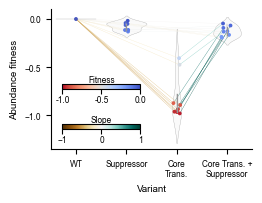

In [33]:
import random
plt.rcParams["font.family"] = "Arial"

rescue_single_scatter_df=pd.DataFrame()
rescue_single_scatter_df.at[0,'variant_type']='WT'
rescue_single_scatter_df.at[0,'mutation']='WT'
rescue_single_scatter_df.at[0,'fitness']=fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==''].iloc[0]['fitness']
rescue_single_scatter_df.at[0,'scatter_pos']=0

dod={}
iterator=2
for core_query, rescue_single in top_rescuing_doubles.items():

    core_mutations=[]
    for wt_res, pos, mut_res in zip(fyn_wt_core, fyn_core_pos, core_query):
        if wt_res != mut_res:
            core_mutations.append(wt_res+str(pos+1)+mut_res)
    combined_mutations = sorted(core_mutations +rescue_single.split(','), key=lambda x: (int(x[1:-1]), x[-1]) )
    
    rescue_single_scatter_df.at[iterator,'variant_type']='Permissivity'
    rescue_single_scatter_df.at[iterator,'mutation']=rescue_single
    rescue_single_scatter_df.at[iterator,'fitness']=fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==rescue_single].iloc[0]['fitness']
    rescue_single_scatter_df.at[iterator,'scatter_pos']=1 * random.uniform(0.96,1.04)
    iterator+=1
    
    rescue_single_scatter_df.at[iterator,'variant_type']='Core'
    rescue_single_scatter_df.at[iterator,'mutation']=core_query
    rescue_single_scatter_df.at[iterator,'fitness']=fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==','.join(core_mutations)].iloc[0]['fitness']
    rescue_single_scatter_df.at[iterator,'scatter_pos']=2 * random.uniform(0.96,1.04)
    iterator+=1
    
    rescue_single_scatter_df.at[iterator,'variant_type']='Core+Permi'
    rescue_single_scatter_df.at[iterator,'mutation']=core_query+' + '+rescue_single
    rescue_single_scatter_df.at[iterator,'fitness']=fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==','.join(combined_mutations)].iloc[0]['fitness']
    rescue_single_scatter_df.at[iterator,'scatter_pos']=3 * random.uniform(0.96,1.04)
    iterator+=1
    
    dod[core_query+' + '+rescue_single]=[core_query,rescue_single]

dod['WT'] = [i for i in list(rescue_single_scatter_df['mutation']) if list(rescue_single_scatter_df['variant_type'])[list(rescue_single_scatter_df['mutation']).index(i)]=='Core' or list(rescue_single_scatter_df['variant_type'])[list(rescue_single_scatter_df['mutation']).index(i)]=='Permissivity']

G = nx.from_dict_of_lists(dod)

pos={}
for index, row in rescue_single_scatter_df.iterrows():
    pos[row.mutation] = (row.scatter_pos, row.fitness)

for u,v,d in G.edges(data=True):
    x1=round(pos[u][0],1)
    y1=pos[u][1]
    x2=round(pos[v][0],1)
    y2=pos[v][1]
    
    if x1 > x2:
        slope = (y2-y1)/(x2-x1)
    else:
        slope = (y1-y2)/(x1-x2)
    
    d['slope'] = slope

edges,slopes = zip(*nx.get_edge_attributes(G,'slope').items())

fig, ax = plt.subplots(figsize=(2.6,1.82))

sns.violinplot(x='variant_type', y='fitness', data=rescue_single_scatter_df, color='0.98', linewidth=0.2, ax=ax)
ylim=ax.get_ylim()
xlim=ax.get_xlim()
edges=nx.draw_networkx_edges(G,pos=pos,edge_color=slopes,width=0.2,ax=ax,edge_cmap=plt.cm.BrBG, edge_vmin=-1, edge_vmax=1)
scat=plt.scatter(data=rescue_single_scatter_df,x='scatter_pos',y='fitness',c = orig_cmap(norm(rescue_single_scatter_df['fitness'])), s=3)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.spines[['right', 'top']].set_visible(False)

cax_fitness=fig.add_axes([0.17,0.44,0.3,0.03])
cb_fitness=fig.figure.colorbar(plt.cm.ScalarMappable(cmap=orig_cmap, norm=norm), cax=cax_fitness, orientation='horizontal')
cb_fitness.outline.set_visible(True)
cb_fitness.ax.set_title('Fitness', fontsize=6, pad=1)
cb_fitness.ax.set_xticks(np.arange(-1,0.5,0.5))
cb_fitness.ax.set_xticklabels(np.arange(-1,0.5,0.5), fontsize=6)
cb_fitness.ax.tick_params(axis='both', which='major', pad=1)

cax_slope=fig.add_axes([0.17,0.22,0.3,0.03])
cb_slope=fig.figure.colorbar(edges, orientation='horizontal', cax=cax_slope)
cb_slope.outline.set_visible(True)
cb_slope.ax.set_title('Slope', fontsize=6,pad=1)
cb_slope.ax.set_xticklabels(cb_slope.ax.get_xticklabels(),fontsize=6)
cb_slope.ax.tick_params(axis='both', which='major', pad=1)

ax.set_ylabel('Abundance fitness', fontsize=7)
ax.set_xlabel('Variant', fontsize=7)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=6)
ax.set_xticklabels(['WT', 'Suppressor', 'Core\nTrans.', 'Core Trans. +\nSuppressor'],fontsize=6)

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Fitness_recovery_nat_core_queries_best_double_variant_1fig.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel H

In [34]:
import pandas as pd

predicted_phenotypes = pd.read_csv(path+'Fig6/FYN_suppressor_mochi_order2_sparse_regularized/task_4/predictions/predicted_phenotypes_all.txt',
                                  sep='\t', lineterminator='\n', low_memory=False)
RT=303*0.001987
predicted_phenotypes['mean_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].mean(axis=1)
predicted_phenotypes['std_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].std(axis=1)

predicted_phenotypes['mean']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].mean(axis=1)
predicted_phenotypes['std']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].std(axis=1)

predicted_phenotypes['mean_dG']= predicted_phenotypes['mean_additive_trait']*RT
predicted_phenotypes['std_dG']= predicted_phenotypes['std_additive_trait']*RT

for index, row in predicted_phenotypes.loc[predicted_phenotypes['WT']!=True].iterrows():
    predicted_phenotypes.at[index,'predicted_fitness']=row['fold_'+str(int(row['Fold']))]
    predicted_phenotypes.at[index,'predicted_dG']=row['fold_'+str(int(row['Fold']))+'_additive_trait0']*RT

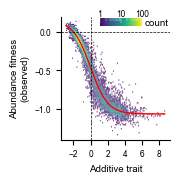

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
plt.rcParams['font.family'] = 'Arial'
predicted_phenotypes=predicted_phenotypes.sort_values(['mean_additive_trait'])
x=predicted_phenotypes['mean_additive_trait']
y=predicted_phenotypes['mean']
def sigmoid(x, L ,x0, k, b): ##https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python
    z = L / (1 + np.exp(-k*(x-x0))) + b
    return (z)

p0 = [max(y), np.median(x),0,min(y)] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, x, y,p0, method='lm')
x_range = np.linspace(x.iloc[0],x.iloc[-1],1000)
y_sig = sigmoid(x_range, *popt)
deriv = np.diff(y_sig)/np.diff(x_range)

fig, ax = plt.subplots(figsize=(1.4,1.6))    

hbin=ax.hexbin(predicted_phenotypes['mean_additive_trait'],predicted_phenotypes['fitness'],bins='log',gridsize=100, cmap='viridis',rasterized=True,linewidths=0, vmax=100)
plt.plot(x_range, y_sig, '-',c='r', linewidth=1)
plt.axvline(0, ls='--', color='black', linewidth=0.5)
plt.axhline(0,  ls='--', color='black', linewidth=0.5)
plt.xlabel('Additive trait', fontsize=7)
plt.xticks(fontsize=6)
plt.ylabel('Abundance fitness\n(observed)', fontsize=7)
plt.yticks(fontsize=6)
ax.set_xticks(np.arange(-2,10,2))
ax.set_yticks(np.arange(-1.5,0.5,0.5))
ax.set_ylim(-1.4,0.2)
#ax.set_xlim(-2,5.5)
ax.spines[['top','right']].set_visible(False)
ax.set_rasterization_zorder(0)
fmt = '%1.f'
cax=fig.add_axes([0.4,0.82,0.3,0.05])
cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
cb.outline.set_visible(False)
cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
cb.ax.xaxis.set_tick_params(pad=0)
#cb.ax.set_title('Count', fontsize=7)
#cb.set_label('count', rotation=0, fontsize=7, labelpad=2)
#cb.ax.xaxis.set_label_position('right')
cb.set_ticks([1,10,100])
cb.set_ticklabels([1,10,100], fontsize=6)
ax1 = cb.ax
ax1.text(140,0.1,'count',rotation=0, fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_suppressor_Mochi_2ndorder_sparsereg.svg', dpi=300, transparent=True, bbox_inches='tight')

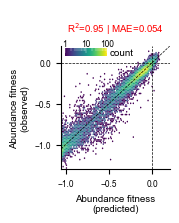

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error

#overall_full_model_performance = pd.DataFrame()

y = predicted_phenotypes.loc[predicted_phenotypes['Nham_aa']>0][['fitness']].to_numpy()
x = predicted_phenotypes.loc[predicted_phenotypes['Nham_aa']>0][['predicted_fitness']].to_numpy()
model = LinearRegression()
model.fit(x,y)
y_pred = model.predict(x)

fig, ax = plt.subplots(figsize=(1.4,1.6))
hbin=ax.hexbin(x=predicted_phenotypes['predicted_fitness'],y=predicted_phenotypes['fitness'],bins='log',gridsize=75,rasterized=True,linewidths=0,vmax=100)
ax.axline((0.1, 0.1), slope=1, linestyle = "dashed", color = 'black',lw=0.5)


plt.axvline(0, ls='--', color='black', lw=0.5)
plt.axhline(0, ls='--', color='black', lw=0.5)
plt.title('\nR$^2$='+str(round(r2_score(y,y_pred),2))+' | MAE='+str(round(mean_absolute_error(y,y_pred),3)),fontsize=7, color='r', loc='center',pad=10)
plt.xlabel('Abundance fitness\n(predicted)', fontsize=7)
plt.xticks(fontsize=6)
plt.ylabel('Abundance fitness\n(observed)', fontsize=7)
plt.yticks(fontsize=6)
ax.set_xticks(np.arange(-1.5,0.5,0.5))
ax.set_yticks(np.arange(-1.5,0.5,0.5))
ax.set_ylim(-1.3,0.2)
ax.set_xlim(-1.05,0.2)
ax.spines[['top','right']].set_visible(False)
ax.set_rasterization_zorder(0)
fmt = '%1.f'
cax=fig.add_axes([0.15,0.82,0.3,0.05])
cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
cb.outline.set_visible(False)
cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
cb.ax.xaxis.set_tick_params(pad=0)
#cb.ax.set_title('Count', fontsize=7)
#cb.set_label('count', rotation=0, fontsize=7, labelpad=2)
#cb.ax.xaxis.set_label_position('right')
cb.set_ticks([1,10,100])
cb.set_ticklabels([1,10,100], fontsize=6)
ax1 = cb.ax
ax1.text(140,0.1,'count',rotation=0, fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_permi_Mochi_2ndorder_sparsereg_performance.svg', dpi=300, transparent=True, bbox_inches='tight')


## Panel I

In [37]:
secondorderterms = pd.read_csv(path+'Fig6/Suppressor_2ndordermodel_secondorderterms_scaled_w_iv_values.txt',sep='\t',index_col=0)

In [38]:
#Calculate residue minimum heavy atom distances from PDB structure

import Bio.PDB
import numpy as np
from Bio.PDB import PDBParser, PDBIO, Select
from Bio.SeqUtils import seq1
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from pathlib import Path


def calc_residue_dist(residue_one, residue_two) :
    """Returns the minimum distance between any atom in two residues (except for backbone C, O and N)"""
    #if 'CB' in residue_one and 'CB' in residue_two:
    all_residue_one_distances=[]
    all_residue_one_distance_names=[]
    residue_one_id= residue_one.get_full_id()[3][1]
    residue_one_chain= residue_one.get_full_id()[2]
    residue_two_id= residue_two.get_full_id()[3][1]
    residue_two_chain= residue_two.get_full_id()[2]
    for atom_one in residue_one:
        atom_one_type=str(atom_one)
        atom_one_type=atom_one_type[6:-1]
        if atom_one_type[0] != 'H' and atom_one_type != 'N' and atom_one_type != 'C' and atom_one_type != 'O': #and atom_one_type != 'CA':
            all_atom_one_distances=[]
            all_atom_dist_names = []
            for atom_two in residue_two:
                atom_two_type=str(atom_two)
                atom_two_type=atom_two_type[6:-1]
                if atom_two_type[0] != 'H' and atom_two_type != 'N' and atom_two_type != 'C' and atom_two_type != 'O': #and atom_two_type != 'CA':
                    diff_vector = atom_one.coord - atom_two.coord
                    all_atom_one_distances.append(np.sqrt(np.sum(diff_vector * diff_vector)))
                    all_atom_dist_names.append('/'+residue_one_chain+':'+str(residue_one_id)+'@'+atom_one_type+'/'+residue_two_chain+':'+str(residue_two_id)+'@'+atom_two_type)
            all_residue_one_distances.append(min(all_atom_one_distances))
            all_residue_one_distance_names.append(all_atom_dist_names[all_atom_one_distances.index(min(all_atom_one_distances))])
    return [min(all_residue_one_distances), all_residue_one_distance_names[all_residue_one_distances.index(min(all_residue_one_distances))]]

def calc_residue_dist_allatom(residue_one, residue_two) :
    """Returns the minimum distance between any atom in two residues"""
    all_residue_one_distances=[]
    all_residue_one_distance_names=[]
    residue_one_id= residue_one.get_full_id()[3][1]
    residue_one_chain= residue_one.get_full_id()[2]
    residue_two_id= residue_two.get_full_id()[3][1]
    residue_two_chain= residue_two.get_full_id()[2]
    for atom_one in residue_one:
        atom_one_type=str(atom_one)
        atom_one_type=atom_one_type[6]
        if atom_one_type != 'H':
            all_atom_one_distances=[]
            all_atom_dist_names = []
            for atom_two in residue_two:
                atom_two_type=str(atom_two)
                atom_two_type=atom_two_type[6]
                if atom_two_type != 'H':
                    diff_vector = atom_one.coord - atom_two.coord
                    all_atom_one_distances.append(np.sqrt(np.sum(diff_vector * diff_vector)))
                    all_atom_dist_names.append('/'+residue_one_chain+':'+str(residue_one_id)+'@'+atom_one_type+'/'+residue_two_chain+':'+str(residue_two_id)+'@'+atom_two_type)
                    #all_atom_one_distances.append(np.linalg.norm(atom_one.coord - atom_two.coord))
            all_residue_one_distances.append(min(all_atom_one_distances))
            all_residue_one_distance_names.append(all_atom_dist_names[all_atom_one_distances.index(min(all_atom_one_distances))])
    return [min(all_residue_one_distances), all_residue_one_distance_names[all_residue_one_distances.index(min(all_residue_one_distances))]]

def calc_dist_matrix(chain_one, chain_two) :
    """Returns a matrix of side-chain distances between two chains"""
    answer = np.zeros((len(chain_one), len(chain_two)), float)
    resseqs = {chain.id:[residue.id[1] for residue in chain.get_residues()] for chain in structure.get_chains()} #Read sequence numbers
    closest_atoms = pd.DataFrame(index=resseqs[chain_one.id],columns=resseqs[chain_two.id])
    for row, residue_one in enumerate(chain_one) :
        for col, residue_two in enumerate(chain_two) :
            closest_atoms.at[row+resseqs[chain_one.id][0],col+resseqs[chain_one.id][1]-1]=calc_residue_dist(residue_one, residue_two)[1]
            answer[row, col] = calc_residue_dist(residue_one, residue_two)[0]
    return [answer, closest_atoms]

def calc_dist_matrix_allatom(chain_one, chain_two) :
    """Returns a matrix of minimum distances between two chains, considering all heavy atoms"""
    answer = np.zeros((len(chain_one), len(chain_two)), float)
    resseqs = {chain.id:[residue.id[1] for residue in chain.get_residues()] for chain in structure.get_chains()} #Read sequence numbers
    closest_atoms = pd.DataFrame(index=resseqs[chain_one.id],columns=resseqs[chain_two.id])
    for row, residue_one in enumerate(chain_one) :
        for col, residue_two in enumerate(chain_two) :
            closest_atoms.at[row+resseqs[chain_one.id][0],col+resseqs[chain_one.id][1]-1]=calc_residue_dist_allatom(residue_one, residue_two)[1]
            answer[row, col] = calc_residue_dist_allatom(residue_one, residue_two)[0]
    return [answer, closest_atoms]


pdb_path = str(Path('~/analyses/Cores/final_submission/zenodo/').expanduser())
pdb_code='5zau'
pdb_filename = pdb_path + '/FigS6/' + pdb_code + '.pdb'

structure = Bio.PDB.PDBParser().get_structure(pdb_code, pdb_filename)
model = structure[0]

chain = 'A'

dist_matrix = calc_dist_matrix(model[chain], model[chain])[0]
closest_atoms = calc_dist_matrix(model[chain], model[chain])[1]

dist_matrix_allatom = calc_dist_matrix_allatom(model[chain], model[chain])[0]
closest_atoms_allatom = calc_dist_matrix_allatom(model[chain], model[chain])[1]

chains = {chain.id:seq1(''.join(residue.resname for residue in chain)) for chain in structure.get_chains()} #Read amino acid sequence
resseqs = {chain.id:[residue.id[1] for residue in chain.get_residues()] for chain in structure.get_chains()} #Read sequence numbers

seq = chains[chain]
seq=list(seq)
seq_nr=resseqs[chain]

In [39]:
fyn_core_pos = [2,16,18,24,26,48,53]

initial_res_in_pdb=85-1
fyn_allatom_distances = pd.DataFrame(data=dist_matrix_allatom, index=np.arange(1,len(seq_nr)+1,1), columns=np.arange(1,len(seq_nr)+1,1))
fyn_sidechain_distances = pd.DataFrame(data=dist_matrix, index=np.arange(1,len(seq_nr)+1,1), columns=np.arange(1,len(seq_nr)+1,1))
secondorderterms["closest_atoms_sidechains"] = pd.Series(dtype="object") 
secondorderterms["closest_atoms_allatom"] = pd.Series(dtype="object") 
secondorderterms["core_coupling"] = pd.Series(dtype="object") 
secondorderterms["3d_dist_allatom_category"] = pd.Series(dtype="object") 
secondorderterms["3d_dist_sidechain_category"] = pd.Series(dtype="object") 
for index, row in secondorderterms.iterrows():
    secondorderterms.at[index,'3d_dist_allatom']=fyn_allatom_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])]
    secondorderterms.at[index,'3d_dist_sidechain']=fyn_sidechain_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])]
    secondorderterms.at[index,'prim_seq_dist']=abs(int(row.mutation1[1:-1])-int(row.mutation2[1:-1]))
    secondorderterms.at[index,'closest_atoms_sidechains']=closest_atoms[int(row.mutation1[1:-1])+initial_res_in_pdb][int(row.mutation2[1:-1])+initial_res_in_pdb]
    secondorderterms.at[index,'closest_atoms_allatom']=closest_atoms_allatom[int(row.mutation1[1:-1])+initial_res_in_pdb][int(row.mutation2[1:-1])+initial_res_in_pdb]
    #if row.mutation1 in fyn_core_singles or row.mutation2 in fyn_core_singles:
    if int(row.mutation1[1:-1]) in [i+1 for i in fyn_core_pos] or int(row.mutation2[1:-1]) in [i+1 for i in fyn_core_pos]:
        secondorderterms.at[index,'core_coupling']=True
    else:
        secondorderterms.at[index,'core_coupling']=False
    
    if fyn_allatom_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] < 5:
        secondorderterms.at[index,'3d_dist_allatom_category']='<5Å'
    elif fyn_allatom_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] > 5 and fyn_allatom_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] <= 10:
        secondorderterms.at[index,'3d_dist_allatom_category']='5-10Å'
    elif fyn_allatom_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] > 10 and fyn_allatom_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] <= 15:
        secondorderterms.at[index,'3d_dist_allatom_category']='10-15Å'
    else:
        secondorderterms.at[index,'3d_dist_allatom_category']='>15Å'
        
    if fyn_sidechain_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] < 5:
        secondorderterms.at[index,'3d_dist_sidechain_category']='<5Å'
    elif fyn_sidechain_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] > 5 and fyn_sidechain_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] <= 10:
        secondorderterms.at[index,'3d_dist_sidechain_category']='5-10Å'
    elif fyn_sidechain_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] > 10 and fyn_sidechain_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] <= 15:
        secondorderterms.at[index,'3d_dist_sidechain_category']='10-15Å'
    else:
        secondorderterms.at[index,'3d_dist_sidechain_category']='>15Å'


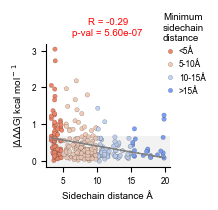

In [40]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1.6,1.6))

hue_order=['<5Å', '5-10Å', '10-15Å', '>15Å']

ax=sns.scatterplot(x='3d_dist_sidechain', y=secondorderterms['scaled_ddGs'].abs(), data=secondorderterms.loc[secondorderterms['core_coupling']==True].sort_values('3d_dist_sidechain', ascending=True), hue='3d_dist_sidechain_category', hue_order=hue_order, palette='coolwarm_r',edgecolor='k', linewidth=0.1, s=10)

scatter_ylim=ax.get_ylim()

ax.axhspan(secondorderterms[secondorderterms['3d_dist_sidechain_category']=='<5Å']['scaled_ddGs'].abs().mean(),ax.get_ylim()[0],facecolor='gray', alpha=0.1)


x = secondorderterms.loc[secondorderterms['core_coupling']==True].sort_values('scaled_ddGs')[['3d_dist_sidechain']].to_numpy()
y = secondorderterms.loc[secondorderterms['core_coupling']==True].sort_values('scaled_ddGs')[['scaled_ddGs']].abs().to_numpy()


model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r,p = pearsonr(y.ravel(),x.ravel())

plt.plot(x, y_pred, color='Gray', linewidth=1, linestyle='--')

ax.set_ylim(scatter_ylim)
ax.set_xticks(np.arange(5,25,5))
for label in ax.get_xticklabels():
    label.set_fontsize(6)
for label in ax.get_yticklabels():
    label.set_fontsize(6)
ax.spines[['right', 'top']].set_visible(False)

legend=plt.legend(bbox_to_anchor=(1.35,1.31), fontsize=6,frameon=False, handletextpad=0.1, title='Minimum\nsidechain\ndistance')
legend.get_title().set_fontsize('7')
plt.xlabel('Sidechain distance Å', fontsize=7)
plt.ylabel('|ΔΔΔG| kcal mol$^-$$^1$', fontsize=7)
plt.title('R = '+str(round(r,2))+ '\np-val = '+'{:0.2e}'.format(p), fontsize=7, color='red')

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Suppressor_couplings_vs_dist.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel J

In [41]:
for index, row in secondorderterms.iterrows():
    if int(row.Pos.split('_')[0])-1 in fyn_core_pos and int(row.Pos.split('_')[1])-1 in fyn_core_pos:
        secondorderterms.at[index,'both_are_core']=True
    else:
        secondorderterms.at[index,'both_are_core']=False

In [42]:
# Select top 10 stabilizing couplings regardless of distance

residues_to_select=[]
for index, row in secondorderterms.loc[secondorderterms['core_coupling']==True].loc[secondorderterms['both_are_core']==False].sort_values('scaled_ddGs', ascending=True).head(20).iterrows():
    print('distance '+row.closest_atoms_sidechains)
    if '/'+row.closest_atoms_sidechains.split('/')[1].split('@')[0] not in residues_to_select:
        residues_to_select.append('/'+row.closest_atoms_sidechains.split('/')[1].split('@')[0])
    if '/'+row.closest_atoms_sidechains.split('/')[2].split('@')[0] not in residues_to_select:
        residues_to_select.append('/'+row.closest_atoms_sidechains.split('/')[2].split('@')[0])
print('select ' + ' '.join(residues_to_select))


distance /A:109@CE2/A:89@CB
distance /A:122@CB/A:87@CB
distance /A:123@CA/A:109@CA
distance /A:133@CD1/A:122@CB
distance /A:109@CE2/A:89@CB
distance /A:87@CA/A:86@CA
distance /A:96@CA/A:87@CB
distance /A:96@CA/A:87@CB
distance /A:127@OG1/A:109@CE1
distance /A:133@CA/A:132@CA
distance /A:133@CG1/A:121@CA
distance /A:87@CA/A:86@CA
distance /A:137@CB/A:103@CZ
distance /A:133@CG1/A:121@CA
distance /A:133@CD1/A:108@CA
distance /A:109@CZ/A:105@CA
distance /A:138@CG2/A:121@CA
distance /A:111@CG1/A:86@CA
distance /A:121@CA/A:111@CG2
distance /A:122@CB/A:111@CA
select /A:109 /A:89 /A:122 /A:87 /A:123 /A:133 /A:86 /A:96 /A:127 /A:132 /A:121 /A:137 /A:103 /A:108 /A:105 /A:138 /A:111


In [43]:
import matplotlib
cmap = matplotlib.cm.get_cmap('Greys_r')

top_stabilizing_couplings = secondorderterms.loc[secondorderterms['core_coupling']==True].loc[secondorderterms['both_are_core']==False].sort_values('scaled_ddGs', ascending=True).head(20).copy()

top_stabilizing_couplings['normalized_kcal_mol'] = (top_stabilizing_couplings['scaled_ddGs'] - (-3)) / (0-(-3))

with open(pdb_path+'/Fig6/fyn_suppressor_top20_stabilizing_couplings_chimerax.pb', 'w') as file:
    for index, row in top_stabilizing_couplings.iterrows():
        file.write('; halfbond = false\n')
        file.write('; color = '+','.join(str(v*100) for v in list(cmap(row.normalized_kcal_mol)))+'\n')
        file.write('; radius = '+str(0.2-0.15*row.normalized_kcal_mol)+'\n')
        file.write('; dashes = 1\n')
        file.write('/1/'+row.closest_atoms_sidechains.split('/')[1]+ ' /1/'+ row.closest_atoms_sidechains.split('/')[2]+'\n')